In [1]:
# This script detects faces in picture, rotates the pictures automatically according to the exif tag (jhead must be installed)
# asks for the Names of the people and adds the names as in the Note field of the Exif info.
# It uses the face_recognition library to detect automatically faces. 
# It then writes the names as "Jon Doe, John Smith, ..." to the comment exif tag  (in the order from left to right)

########## Install Instructions
# conda install -c menpo dlib 
# pip install face_recognition
# pip qutip

import face_recognition
import os, sys,stat
import numpy as np
import piexif
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle #pickle.dump( data, open( "file.save", "wb" ) ) #data = pickle.load( open( "file.save", "rb" ) )
import subprocess 
from pathlib import Path 
import PIL.Image
import PIL.ExifTags
from qutip import parallel



plt.rcParams['toolbar'] = 'None'

## Functions

In [2]:
def in_notebook():
    """
    Returns ``True`` if the module is running in IPython kernel,
    ``False`` if in IPython shell or other Python shell.
    """
    return 'ipykernel' in sys.modules

if in_notebook():
    print('Running in Notebook')
else:
    print('Running in Shell')

    

def exif_info(path):
    exif = {'DateTimeOriginal':''}
    try:
        img = PIL.Image.open(path)
        exif = {
            PIL.ExifTags.TAGS[k]: v
            for k, v in img._getexif().items()
            if k in PIL.ExifTags.TAGS
        }
    except :
        print('Error in exif info loading')
    return exif

def ExpandDirectories(flist, ending='.jpg', not_conatin=None):
    newplotfiles = []
    if isinstance(flist,str):
        flist = [flist]
    for directory in flist:
        if os.path.isdir(directory):
            for dirpath, dirnames, files in os.walk(directory, followlinks=True):
                for name in files:
                    if (ending.lower() in name.lower()) and (not_conatin==None or not_conatin not in name  ):
                        newplotfiles += [os.path.join(dirpath, name)]
#                         print('Include '+name)
        elif os.path.isfile(directory):
            newplotfiles += [directory]
    return newplotfiles




def ShowImg(pic, title='', trim=None, Timer=1):
    if isinstance(pic,str):
        data = mpimg.imread(pic)
    else:
        data = pic
    if trim!=None:
        fig = plt.imshow(data[trim[0]:trim[2],trim[3]:trim[1]])
    else:
        fig = plt.imshow(data)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.suptitle(title) 
    if Timer!=None:
        plt.show(block=False)
        if not in_notebook(): plt.pause(Timer)
        plt.close()
    else:
        plt.show(block=False)
        if not in_notebook(): plt.pause(0.3)
    return data


def arr2str(arr, sep=', ', pre_counter=False, pre_counter_str=' = '):
    output = ''
    for i,item in enumerate(arr):
        if pre_counter:      output += str(i)+pre_counter_str
        output += str(item)
        if i<len(arr)-1:     output += sep
    return output
        

def ExeCmd(cmd, errormessage='Error'):
    try:
        output = subprocess.check_output(cmd, shell=True)
        if output!= "b''":
            print(output) 
        return output
    except: 
        print(errormessage)    
    
def RotateImg(pic):
    ExeCmd("jhead -autorot \'"+pic+"\'", errormessage= 'Could not rotate picture. Is jhead installed?')
    
    
def MultipleChoice(arr, pre='', post ='Please select:'):
    text = pre+arr2str(arr, sep='\n', pre_counter=True)+'\n'+post+'\n'
    return input(text)
    
# MultipleChoice(['a','b','c'])




def Path2Dir(path,   end_sep=True):
    directory = os.path.dirname(path)
    if end_sep:
        directory = directory+sep_char
    return directory


def Path2Filename(path,  RemoveEnding = False ): 
    filename = os.path.basename(path)
    if RemoveEnding:
        filename = '.'.join(filename.split('.')[:-1])
    return filename



Running in Notebook


## Arguments

In [3]:
args = {
    'folder' : ['demo'],
    'database' : 'Face_encodings_tmp.save',
    'shuffle' : True,
    'softlinks' : True,
    'softlink_folder' : 'People folders',
    'ignore_readonly' : True,
    'training' : True,
    'tolerance' : 0.48 ,
}


if not in_notebook():
    import argparse

    parser = argparse.ArgumentParser(description='Detect Faces and write them in the exif tag')
    parser.add_argument('-f','--folder',nargs='*', help='Picture folders',type=str , default=args['folder'])
    parser.add_argument('--database', help='Database File, storing the face encodings',type=str , default=args['database'])
    parser.add_argument('--shuffle', type=lambda s: s.lower() in ['true', 't', 'yes', '1'], default=args['shuffle'])
 
    for k,v in vars(parser.parse_args()).items():
        args[k] = v
    


## Load Database

In [4]:
if  os.path.exists(args['database']): 
    faces = pickle.load( open( args['database'], "rb" ) )
else:
    faces = {
        'encs' : [np.zeros([128])]    ,
        'names' : np.array(['0'])     ,       
    }
    
    
    

In [5]:
def deletePerson(k):
    print(faces['names'])
    if input('Delte  '+str(faces['names'][faces['names']==k    ])+'  (y/n)') =='y':        
        mask = faces['names']!=k    
        faces['names'] = faces['names'][mask]
        faces['encs'] = faces['encs'][mask]
        
# pickle.dump( faces, open( args['database'], "wb" ) ) #data = pickle.load( open( "file.save", "rb" ) )        

## Recognize Faces

In [6]:
pics = np.array(ExpandDirectories(args['folder']))
if args['shuffle']:
    np.random.shuffle(pics)

In [ ]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

cpu_count = len(pics)//10
splitted_pics = split_list(pics,wanted_parts=cpu_count)

------------------------------0.00% ,   0/44
Loading: demo/2016 Weihnachten/DSC05234.JPG
b''


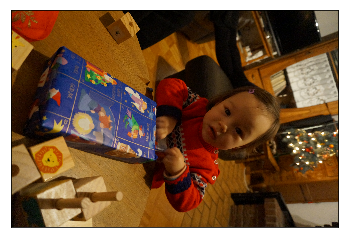

Detecting faces....
No faces found.
------------------------------2.27% ,   1/44
Loading: demo/2016 Weihnachten/DSC05220.JPG
b''


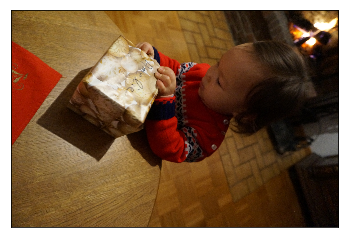

Detecting faces....


In [ ]:
def ChooseClosestMatch(matches_bool, src_enc, faces, loc, show_img=True):
    red_faces = faces['names'][matches_bool]
    distances = face_recognition.face_distance(faces['encs'][matches_bool], src_enc)
    print('Multiple possible Faces found:\n'+ 
          arr2str(["{0:.2f}".format(d)+'  '+name for d,name in zip(distances,red_faces)], sep='\n'))         
    name = red_faces[np.argmin(distances)]
    if show_img:  ShowImg(pic,title=name,  trim=loc, Timer=1)
    print('Choosing the closest match: '+name)     
    return name

def AddFace(name,enc, faces):
    faces['encs'] = np.vstack([faces['encs'],enc])
    faces['names'] = np.hstack([faces['names'],name])
    return faces

        
def ProcessPic(pic_idx, pic, faces)        :    
    training = args['training']
#     print("------------------------------"+"{0:.2f}".format(pic_idx/len(pics)*100)+'% ,   '+str(pic_idx)+'/'+str(len(pics)))
    print('Loading: '+pic)
    try:
        # make it writable
        if args['ignore_readonly']:
            st = os.stat(pic)
            os.chmod(pic, st.st_mode | stat.S_IWUSR)


        RotateImg(pic)
        
        if  training:   ShowImg(pic, Timer=None)

        print('Detecting faces....')
        image = face_recognition.load_image_file(pic)
        locs = face_recognition.face_locations(image)
        encs = face_recognition.face_encodings(image, known_face_locations=locs)


        # sort according to x coordinate  (left to right)
        x_coors = np.array([l[1] for l in locs])
        sort_idxs = np.argsort(x_coors)
        locs = [locs[idx] for idx in sort_idxs]
        encs = [encs[idx] for idx in sort_idxs]

        if  training:   plt.close()

        # recognize each face
        if len(encs) ==0: print('No faces found.')
        names = []
        for i in range(len(encs)):
            matches_bool = np.array(face_recognition.compare_faces(faces['encs'], encs[i], tolerance=args['tolerance']) )
            
            if matches_bool.any():
                names += [ChooseClosestMatch(matches_bool, encs[i],faces, locs[i], show_img=training)]            
            else:
                if training:
                    ShowImg(pic, trim=locs[i], Timer=None)
                    print('Extending tolerance:')
                    matches_bool = np.array(face_recognition.compare_faces(faces['encs'], encs[i], tolerance=1) )
                    if matches_bool.any():
                        new_name = ChooseClosestMatch(matches_bool, encs[i], faces, locs[i], show_img=False)
                        mc = MultipleChoice([new_name+' is correct.', 
                                             'empty for Skip', 
                                             'Skip all unknown faces from now on. The detection is good enough.', 
                                             'Write any name to add it'], 
                                          post='Please enter a number or a new name.')
                        if mc =='2':  
                            training = False
                            names += ["unknown"]
                        elif mc !='0':  
                            new_name = mc   # mc can be empty. then it will skip later
                    else:                        
                        new_name = input('Please name this face (empty if you want to skip): ')
                    if training:   plt.close()

                    if  training and new_name!='':
                        names += [new_name]
                        faces = AddFace(new_name, encs[i], faces)
                    else:
                        print('Ok. Skipping.')
                else:
#                     ShowImg(pic, trim=locs[i], Timer=1)
                    names += ["unknown"]
                    


        if len(names)>0:   # only do something if there were faces
            cleaned_names = [name for name in names if name !="unknown"]
            print('Writing names to exif tag: '+arr2str(cleaned_names))
            output = ExeCmd("jhead -cl \'"+arr2str(cleaned_names)+"\'   \'" + pic+"\'" , errormessage='Error: Could not write Tags.' )     

            # save the database if names were added
            if training:
                pickle.dump( faces, open( args['database'], "wb" ) ) #data = pickle.load( open( "file.save", "rb" ) )

        # save softlink  (even if the name is "unknown")
        if args['softlinks'] and len(pics)>1:
            for name in names:
                namefolder = os.path.join(args['folder'][0],'..', args['softlink_folder'], name)
                if not os.path.exists(namefolder):    os.makedirs(namefolder)    
                relative_from_subfolder = os.path.join('..','..',pic)
                dst = os.path.join(namefolder,
                       exif_info(pic)['DateTimeOriginal'].replace(':','-')
                       +' '
                       + Path2Filename(pic)) 
                if not os.path.exists(dst):
                    os.symlink(relative_from_subfolder, dst)
    except KeyboardInterrupt: 
        raise
#     except:
#         print('Error in processing image. Skipping.')    
    return  faces, names, training
    
        

        
        

for pic_idx, pic in enumerate(pics):
    print("------------------------------"+"{0:.2f}".format(pic_idx/len(pics)*100)+'% ,   '+str(pic_idx)+'/'+str(len(pics)))
    faces, names, args['training'] = ProcessPic(pic_idx, pic, faces)    

In [ ]:
faces